## Future Work - Over sampling (SMOTE)

This notebook uses heavy machines types to run oversampling based SMOTENC algorithm.

- For Numerical Features: 
For each minority sample, SMOTE picks one of its nearest neighbors and for each of thenumerical features, it creates a synthetic feature value by interpolating between the sample and the neighbor using a random weight. This produces a synthetic sample that is similar to the original samples, but helps balance the dataset.

- For Categorical Features:
Interpolation doesn't make sense (you can’t average "red" and "blue"), so instead it picks a category value from the chosen neighbor (or sometimes uses a majority vote among the neighbors).

!!! Please note, this is just a bonus for future work. the main notebook with all the experiment is `Fraud_Detection_Hackathon.ipynb`.
The conclusions about SMOTENC are described in the main notebook.

In [0]:
!pip uninstall -y pandas numpy
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install xgboost
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.6.1
!pip install imbalanced-learn

Found existing installation: pandas 1.5.3
Not uninstalling pandas at /databricks/python3/lib/python3.11/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-91ab9c6a-162c-4f76-a9f1-c4fdb014e1a5
Can't uninstall 'pandas'. No files were found to uninstall.
Found existing installation: numpy 1.23.5
Not uninstalling numpy at /databricks/python3/lib/python3.11/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-91ab9c6a-162c-4f76-a9f1-c4fdb014e1a5
Can't uninstall 'numpy'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for pandas==2.2.2 from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7ddd7e3f6/pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.py

In [0]:
dbutils.library.restartPython()

In [0]:
import os
import mlflow
cwd = os.getcwd()
volume_path = os.path.relpath("/Volumes/insights_prod/research/xgboost_research", start=cwd)
mlflow.set_experiment("/Users/guy.l@lusha.com/Recommendations/fraud_detection")

TRAIN_TRANSACTION_PATH = "/Volumes/insights_prod/research/xgboost_research/train_transaction.csv"
TRAIN_IDENTITY_PATH = "/Volumes/insights_prod/research/xgboost_research/train_identity.csv"
TEST_TRANSACTION_PATH = "/Volumes/insights_prod/research/xgboost_research/test_transaction.csv"
TEST_IDENTITY_PATH = "/Volumes/insights_prod/research/xgboost_research/test_identity.csv"
SUBMIT_PATH = "/Volumes/insights_prod/research/xgboost_research/submission.csv"
SAMPLE_SUBMISSION_PATH = "/Volumes/insights_prod/research/xgboost_research/sample_submission.csv"

### Data Loader

In [0]:
""" Data loader module """
import pandas as pd
from typing import Tuple, Dict

def get_data_dtypes():
    """Define and return dtypes for all datasets."""
    dtypes_train_transaction = {
        'TransactionID': 'int32',
        'isFraud': 'int8',
        'TransactionDT': 'int32',
        'TransactionAmt': 'float32',
        'ProductCD': 'object',
        'card1': 'object',
        'card2': 'object',
        'card3': 'object',
        'card4': 'object',
        'card5': 'object',
        'card6': 'object',
        'addr1': 'float32',
        'addr2': 'float32',
        'dist1': 'float32',
        'dist2': 'float32',
        'P_emaildomain': 'object',
        'R_emaildomain': 'object',
        **{f'C{i}': 'float32' for i in range(1, 15)},
        **{f'D{i}': 'float32' for i in range(1, 16)},
        **{f'M{i}': 'object' for i in range(1, 10)},
        **{f'V{i}': 'float32' for i in range(1, 340)}
    }

    dtypes_train_identity = {
        **{f'id_{i:02}': 'float32' for i in range(1, 12)},
        'id_12': 'object',
        'id_13': 'float32',
        'id_14': 'float32',
        'id_15': 'object',
        'id_16': 'object',
        **{f'id_{i:02}': 'float32' for i in range(17, 40)},
        **{f'id_{i:02}': 'object' for i in range(23, 39)},
        'DeviceType': 'object',
        'DeviceInfo': 'object'
    }

    dtypes_test_transaction = dtypes_train_transaction.copy()
    del dtypes_test_transaction['isFraud']

    dtypes_test_identity = dtypes_train_identity.copy()

    return dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity

def load_raw_data(dtypes_train_transaction: Dict, dtypes_train_identity: Dict, dtypes_test_transaction: Dict,
                  dtypes_test_identity: Dict, local_path: str) -> Tuple[pd.DataFrame, ...]:
    """Load raw data from CSV files."""
    TRANSACTION_TRAIN_PATH = TRAIN_TRANSACTION_PATH
    IDENTITY_TRAIN_PATH = TRAIN_IDENTITY_PATH
    TRANSACTION_TEST_PATH = TEST_TRANSACTION_PATH
    IDENTITY_TEST_PATH = TEST_IDENTITY_PATH

    train_transaction = pd.read_csv(TRANSACTION_TRAIN_PATH, dtype=dtypes_train_transaction)
    train_identity = pd.read_csv(IDENTITY_TRAIN_PATH, dtype=dtypes_train_identity)
    test_transaction = pd.read_csv(TRANSACTION_TEST_PATH, dtype=dtypes_test_transaction)
    test_identity = pd.read_csv(IDENTITY_TEST_PATH, dtype=dtypes_test_identity)

    return train_transaction, train_identity, test_transaction, test_identity

def merge_datasets(train_transaction: pd.DataFrame, train_identity: pd.DataFrame,
                   test_transaction: pd.DataFrame, test_identity: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """Merge transaction and identity datasets."""
    # Standardize column names
    test_identity.columns = test_identity.columns.str.replace('-', '_')
    test_transaction.columns = test_transaction.columns.str.replace('-', '_')

    # Merge datasets
    train = train_transaction.merge(train_identity, how='left', on='TransactionID')
    test = test_transaction.merge(test_identity, how='left', on='TransactionID')

    return train, test



### Data processing 

In [0]:
""" Data Prepreocess Module"""
import pandas as pd
import numpy as np
from typing import Tuple, List
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings("ignore")

def get_top_missing_cols(df: pd.DataFrame ,n: int=10,thresh: int =80) -> pd.DataFrame:
    """
    Returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """

    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

def drop_high_missing_columns(train: pd.DataFrame, test: pd.DataFrame,
                              missing_train_df: pd.DataFrame, missing_test_df: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Drop columns with high missing value percentages.
    """
    train = train.drop(columns=missing_train_df['col'].tolist()[:-1])
    test = test.drop(columns=missing_test_df['col'].tolist()[:-1])

    # Drop additional problematic columns
    train.drop(columns='V107', inplace=True)
    test.drop(columns='V107', inplace=True)

    return train, test

def create_time_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Create day and hour features from TransactionDT.
    """

    def apply_fraud_hour_feature(hr):
      if hr >= 7 and hr < 10:
          return "HighestFraudProb"
      if hr >= 14 and hr < 16:
          return "LowestFraudProb"
      if (hr >= 4 and hr < 7) or (hr >= 10 and hr < 14):
          return "MediumFraudProb"
      else:
          return "LowFraudProb"

    # Create day of week feature (1-7)
    train['day'] = ((train['TransactionDT'] // (3600*24) - 1) % 7) + 1
    test['day'] = ((test['TransactionDT'] // (3600*24) - 1) % 7) + 1

    # Create hour of day feature (1-24)
    train['hour'] = ((train['TransactionDT'] // 3600) % 24) + 1
    test['hour'] = ((test['TransactionDT'] // 3600) % 24) + 1

    # Create hour fraud probability category
    train['hour_fraud_prob'] = train['hour'].apply(apply_fraud_hour_feature)
    test['hour_fraud_prob'] = test['hour'].apply(apply_fraud_hour_feature)

    return train, test

def create_transaction_amount_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Clean and transform TransactionAmt feature.
    """
    # Remove high transaction amount outliers
    train.drop(train[train.TransactionAmt > 10000].index, axis=0, inplace=True)

    # Create log transformed amount feature
    train['LogTransactionAmt'] = np.log(train['TransactionAmt'])
    test['LogTransactionAmt'] = np.log(test['TransactionAmt'])

    return train, test

def create_card_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Create features based on card information.
    """

    def apply_card_to_fraud_high_prob(row):
        if row == np.nan:
            return row
        else:
            if float(row) > 160:
                return 'True'
            else:
                return 'False'

    train['prob_card3'] = train['card3'].apply(apply_card_to_fraud_high_prob)
    test['prob_card3'] = test['card3'].apply(apply_card_to_fraud_high_prob)

    return train, test

def create_product_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Create features based on product information.
    """

    def apply_product_fraud_risk(product_cd):
      if product_cd == np.nan:
          return product_cd
      else:
          if product_cd == 'C':
              return "True"
          else:
              return "False"

    train['product_fraud_risk'] = train['ProductCD'].apply(apply_product_fraud_risk)
    test['product_fraud_risk'] = test['ProductCD'].apply(apply_product_fraud_risk)

    return train, test


def process_email_domains(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Clean and categorize email domains.
    """
    for df in [train, test]:
        # Process purchaser email domains (P_emaildomain)
        # Group Google domains
        df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']), 'P_emaildomain'] = 'Google'

        # Group Yahoo domains
        df.loc[df['P_emaildomain'].isin([
            'yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp',
            'yahoo.de', 'yahoo.fr', 'yahoo.es'
        ]), 'P_emaildomain'] = 'Yahoo'

        # Group Microsoft domains
        df.loc[df['P_emaildomain'].isin([
            'hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 'hotmail.es',
            'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr',
            'hotmail.fr'
        ]), 'P_emaildomain'] = 'Microsoft'

        # Group rare domains
        df.loc[df.P_emaildomain.isin(
            df.P_emaildomain.value_counts()[df.P_emaildomain.value_counts() <= 500].index
        ), 'P_emaildomain'] = "Others"

        # Fill missing values
        df.P_emaildomain.fillna("Unknown", inplace=True)

        # Process receiver email domains (R_emaildomain)
        # Group Google domains
        df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']), 'R_emaildomain'] = 'Google'

        # Group Yahoo domains
        df.loc[df['R_emaildomain'].isin([
            'yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp',
            'yahoo.de', 'yahoo.fr', 'yahoo.es'
        ]), 'R_emaildomain'] = 'Yahoo'

        # Group Microsoft domains
        df.loc[df['R_emaildomain'].isin([
            'hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 'hotmail.es',
            'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr',
            'hotmail.fr'
        ]), 'R_emaildomain'] = 'Microsoft'

        # Group rare domains
        df.loc[df.R_emaildomain.isin(
            df.R_emaildomain.value_counts()[df.R_emaildomain.value_counts() <= 300].index
        ), 'R_emaildomain'] = "Others"

        # Fill missing values
        df.R_emaildomain.fillna("Unknown", inplace=True)

    return train, test

def remove_outliers(train: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from numerical C features.
    """
    train.drop(train[train.C1 > 3000].index, axis=0, inplace=True)
    train.drop(train[train.C2 > 3000].index, axis=0, inplace=True)
    train.drop(train[train.C7 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C4 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C6 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C7 > 1400].index, axis=0, inplace=True)
    train.drop(train[train.C8 > 1000].index, axis=0, inplace=True)
    train.drop(train[train.C10 > 1000].index, axis=0, inplace=True)
    train.drop(train[train.C11 > 2000].index, axis=0, inplace=True)
    train.drop(train[train.C12 > 2000].index, axis=0, inplace=True)
    train.drop(train[train.C13 > 1200].index, axis=0, inplace=True)
    train.drop(train[train.C14 > 800].index, axis=0, inplace=True)

    return train

def transform_device_info(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform DeviceInfo into standardized device corporation categories.
    """
    df['DeviceCorp'] = df['DeviceInfo']

    # Brand mappings
    df.loc[df['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    df.loc[df['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    df.loc[df['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    df.loc[df['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    df.loc[df['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    df.loc[df['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    df.loc[df['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    df.loc[df['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    df.loc[df['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    df.loc[df['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    df.loc[df['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    df.loc[df['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    df.loc[df['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'

    # Extract first part of device info as fallback
    df['DeviceCorp'] = df['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
                            str.split('-', expand=True)[0].str.split(expand=True)[0]

    # Additional specific mappings
    df.loc[df['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    df.loc[df['DeviceInfo'].str.startswith('Z', na=False), 'DeviceCorp'] = 'ZTE'
    df.loc[df['DeviceInfo'].str.startswith('KF', na=False), 'DeviceCorp'] = 'Amazon'

    # Sony device mappings
    for i in ['D', 'E', 'F', 'G']:
        df.loc[df['DeviceInfo'].str.startswith(i, na=False), 'DeviceCorp'] = 'SONY'

    # Group rare device corporations
    df.loc[df['DeviceCorp'].isin(df['DeviceCorp'].value_counts()\
                               [df['DeviceCorp'].value_counts() < 100].index), 'DeviceCorp'] = 'Other'

    # Standardize to uppercase
    df['DeviceCorp'] = df['DeviceCorp'].str.upper()

    return df

def create_device_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Create features from device information fields (id_30, id_31).
    """

    def setting_nan(value):
        """
        Convert 'NAN' string values to actual np.nan.
        """
        if value == 'NAN':
            return np.nan
        else:
            return value

    # Extract OS and version from id_30
    train['OS_id_30'] = train['id_30'].str.split(' ', expand=True)[0]
    train['version_id_30'] = train['id_30'].str.split(' ', expand=True)[1]
    test['OS_id_30'] = test['id_30'].str.split(' ', expand=True)[0]
    test['version_id_30'] = test['id_30'].str.split(' ', expand=True)[1]

    # Extract browser and version from id_31
    train['browser_id_31'] = train['id_31'].str.split(' ', expand=True)[0]
    train['version_id_31'] = train['id_31'].str.split(' ', expand=True)[1]
    test['browser_id_31'] = test['id_31'].str.split(' ', expand=True)[0]
    test['version_id_31'] = test['id_31'].str.split(' ', expand=True)[1]

    train = transform_device_info(train)
    test = transform_device_info(test)

    # Fix 'NAN' values
    train['DeviceCorp'] = train['DeviceCorp'].apply(setting_nan)
    test['DeviceCorp'] = test['DeviceCorp'].apply(setting_nan)

    return train, test


def get_categorical_features(baseline=False) -> List:
    """Return list of categorical features."""
    categorical_features = [
        'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain',
        'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
        'DeviceType', 'DeviceInfo', 'hour_fraud_prob', 'LogTransactionAmt',
        'prob_card3', 'product_fraud_risk', 'OS_id_30', 'version_id_30',
        'browser_id_31', 'version_id_31', 'DeviceCorp'
    ]

    if baseline:
        categorical_features = categorical_features[:20]

    categorical_features += [f'id_{i}' for i in range(12, 39)]
    return categorical_features

def encode_categorical_features(train: pd.DataFrame, 
                                val: pd.DataFrame, 
                                test: pd.DataFrame,
                                categorical_features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Encode categorical features using LabelEncoder on train, validation, and test sets."""
    for col in categorical_features:
        if col in train.columns:
            # Convert to string
            train[col] = train[col].astype(str)
            val[col] = val[col].astype(str)
            test[col] = test[col].astype(str)
            
            # Combine the column from all datasets to capture all categories
            combined_data = pd.concat([train[col], val[col], test[col]], axis=0)
            le = LabelEncoder()
            le.fit(combined_data)
            
            # Transform each dataset
            train[col] = le.transform(train[col])
            val[col] = le.transform(val[col])
            test[col] = le.transform(test[col])
    return train, val, test

def get_categorical_features_indices(train, baseline=False):
    """Return list of categorical features and their indices."""
    categorical_features = [
        'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain',
        'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
        'DeviceType', 'DeviceInfo', 'hour_fraud_prob', 'LogTransactionAmt',
        'prob_card3', 'product_fraud_risk', 'OS_id_30', 'version_id_30',
        'browser_id_31', 'version_id_31', 'DeviceCorp'
    ]

    if baseline:
        categorical_features = categorical_features[:20]

    categorical_features += [f'id_{i}' for i in range(12, 39)]

    # First get the column names of your dataframe excluding TransactionID and isFraud
    all_features = train.drop(['TransactionID', 'isFraud'], axis=1, errors="ignore").columns

    # Get indices of categorical features
    cat_indices = [list(all_features).index(col) for col in categorical_features if col in all_features]

    return categorical_features, cat_indices


def normalize_d_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    train['D1n'] = np.floor(train.TransactionDT / (24*60*60)) - train.D1
    train['D2n'] = np.floor(train.TransactionDT / (24*60*60)) - train.D2
    train['D3n'] = np.floor(train.TransactionDT / (24*60*60)) - train.D3
    train['D15n'] = np.floor(train.TransactionDT / (24*60*60)) - train.D15
    test['D1n'] = np.floor(test.TransactionDT / (24*60*60)) - test.D1
    test['D2n'] = np.floor(test.TransactionDT / (24*60*60)) - test.D2
    test['D3n'] = np.floor(test.TransactionDT / (24*60*60)) - test.D3
    test['D15n'] = np.floor(test.TransactionDT / (24*60*60)) - test.D15

    return train, test


def run_feature_engineering(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, ...]:
    """
    Run the complete feature engineering pipeline.
    """
    missing_train_df = get_top_missing_cols(train, thresh=90)
    missing_test_df = get_top_missing_cols(test, thresh=90)

    # Drop columns with high missing values
    train, test = drop_high_missing_columns(train, test, missing_train_df, missing_test_df)

    # Remove outliers from train data
    train = remove_outliers(train)

    # Create time-based features
    train, test = create_time_features(train, test)
    train, test = normalize_d_features(train, test)

    # Process transaction amounts
    train, test = create_transaction_amount_features(train, test)

    # Create card features
    train, test = create_card_features(train, test)

    # Create product features
    train, test = create_product_features(train, test)

    # Process email domains
    train, test = process_email_domains(train, test)

    # Create device features
    train, test = create_device_features(train, test)
    
    return train, test


### Model utils

In [0]:
""" Model Utils Module """
import pandas as pd
import numpy as np
from typing import Dict, Tuple, List, Optional
import xgboost as xgb
from datetime import datetime, timezone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, \
 roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from imblearn.over_sampling import SMOTENC


def impute_missing_values(X_train: pd.DataFrame, 
                          X_val: pd.DataFrame, 
                          X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Impute missing values:
      - Numeric features are imputed with the mean.
      - Categorical features are imputed with the most frequent value.
      
    Numeric features are selected based on dtypes (int8, int16, int32, int64, float32, float64)
    excluding 'TransactionID' and 'isFraud'.
    """
    # Identify numeric features based on specific dtypes
    numeric_features = X_train.select_dtypes(include=['int8','int16','int32','int64','float32','float64']).columns.tolist()
    numeric_features = [col for col in numeric_features if col not in ['TransactionID', 'isFraud']]
    
    # Identify categorical features: all columns not in numeric_features and not in ['TransactionID', 'isFraud']
    categorical_features = [col for col in X_train.columns if col not in numeric_features and col not in ['TransactionID', 'isFraud']]
    
    # Impute numeric features with mean
    imputer_numeric = SimpleImputer(strategy="mean")
    X_train_numeric = pd.DataFrame(imputer_numeric.fit_transform(X_train[numeric_features]),
                                   columns=numeric_features, index=X_train.index)
    X_val_numeric   = pd.DataFrame(imputer_numeric.transform(X_val[numeric_features]),
                                   columns=numeric_features, index=X_val.index)
    X_test_numeric  = pd.DataFrame(imputer_numeric.transform(X_test[numeric_features]),
                                   columns=numeric_features, index=X_test.index)
    
    # Impute categorical features with the most frequent value
    imputer_categorical = SimpleImputer(strategy="most_frequent")
    X_train_cat = pd.DataFrame(imputer_categorical.fit_transform(X_train[categorical_features]),
                               columns=categorical_features, index=X_train.index)
    X_val_cat   = pd.DataFrame(imputer_categorical.transform(X_val[categorical_features]),
                               columns=categorical_features, index=X_val.index)
    X_test_cat  = pd.DataFrame(imputer_categorical.transform(X_test[categorical_features]),
                               columns=categorical_features, index=X_test.index)
    
    # Combine the imputed numeric and categorical features, preserving the original column order
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    for col in numeric_features:
        X_train_imputed[col] = X_train_numeric[col]
        X_val_imputed[col] = X_val_numeric[col]
        X_test_imputed[col] = X_test_numeric[col]
        
    for col in categorical_features:
        X_train_imputed[col] = X_train_cat[col]
        X_val_imputed[col] = X_val_cat[col]
        X_test_imputed[col] = X_test_cat[col]
    
    return X_train_imputed, X_val_imputed, X_test_imputed

def prepare_data_for_training(train, test, impute = False):
    """Prepare final datasets for model training."""
    X = train.drop(columns=['isFraud', 'TransactionID'])
    y = train['isFraud']
    X_test = test.drop(columns=['TransactionID'], errors='ignore')

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Handle missing values
    if impute:
       X_train, X_val, X_test = impute_missing_values(X_train, X_val, X_test)

    return X_train, X_val, y_train, y_val, X_test

def get_model_params():
    """Return the best model parameters."""
    return {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': 220,
        "learning_rate": 0.08,
        "max_depth": 8,
        "min_child_weight": 5,
        "gamma": 0,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "lambda": 10,
        "alpha": 0
    }

def standardize_numeric_features(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, List[str]]:
    """Standardize numeric features using StandardScaler."""
    numeric_features = train.select_dtypes(
        include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
    ).columns
    numeric_features = [col for col in numeric_features if col not in ['TransactionID', 'isFraud']]

    scaler = StandardScaler()
    train[numeric_features] = scaler.fit_transform(train[numeric_features])
    val[numeric_features] = scaler.transform(val[numeric_features])
    test[numeric_features] = scaler.transform(test[numeric_features])

    return train, val, test, numeric_features


def scale_data(X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame):
    """ Scale the features using StandardScaler, fitting only on X_train to avoid data leakage. """

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame to preserve column names & indices
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    return X_train_scaled, X_val_scaled, X_test_scaled

def reduce_v_features_selectively(X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame, 
                                  n_components: int, top_features: Optional[List[str]]=None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Selectively reduce V features with PCA while keeping top important features.
    Supports train, validation, and test datasets.
    """
    if top_features is None:
        top_features = ['V258', 'V257', 'V201', 'V156', 'V91', 'V294']

    # Get all V feature columns
    all_v_columns = [col for col in X_train.columns if col.startswith('V')]

    # Separate top V features from others
    v_to_pca = [col for col in all_v_columns if col not in top_features]

    print(f"Keeping {len(top_features)} top V features directly")
    print(f"Applying PCA to {len(v_to_pca)} remaining V features")

    # Extract V features for PCA
    train_v = X_train[v_to_pca]
    val_v = X_val[v_to_pca]
    test_v = X_test[v_to_pca]

    # Scale the V features using the helper function
    train_v_scaled, val_v_scaled, test_v_scaled = scale_data(train_v, val_v, test_v)

    # Apply PCA - fit only on training data to prevent data leakage
    pca = PCA(n_components=n_components)
    train_v_pca = pca.fit_transform(train_v_scaled)
    val_v_pca = pca.transform(val_v_scaled)
    test_v_pca = pca.transform(test_v_scaled)

    # Create new column names
    pca_columns = [f'V_PCA_{i+1}' for i in range(n_components)]

    # Convert to DataFrames
    train_v_pca_df = pd.DataFrame(train_v_pca, columns=pca_columns, index=X_train.index)
    val_v_pca_df = pd.DataFrame(val_v_pca, columns=pca_columns, index=X_val.index)
    test_v_pca_df = pd.DataFrame(test_v_pca, columns=pca_columns, index=X_test.index)

    # Drop PCA-transformed V features (keep the top ones)
    train_no_pca_v = X_train.drop(columns=v_to_pca)
    val_no_pca_v = X_val.drop(columns=v_to_pca)
    test_no_pca_v = X_test.drop(columns=v_to_pca)

    # Combine with PCA features
    train_pca = pd.concat([train_no_pca_v, train_v_pca_df], axis=1)
    val_pca = pd.concat([val_no_pca_v, val_v_pca_df], axis=1)
    test_pca = pd.concat([test_no_pca_v, test_v_pca_df], axis=1)

    print(f"Final feature count: {train_pca.shape[1]} (original: {X_train.shape[1]})")
    print(f"PCA variance explained: {sum(pca.explained_variance_ratio_):.4f}")

    return train_pca, val_pca, test_pca

def train_model(X_train: pd.DataFrame, X_val: pd.DataFrame, y_train: pd.DataFrame,
                y_val: pd.DataFrame, model_params: Dict) -> xgb.XGBClassifier:
    """Train and return the XGBoost model."""
    model = xgb.XGBClassifier(**model_params, use_label_encoder=False, early_stopping_rounds=100, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
    )
    return model

def evaluate_model(model: xgb.XGBClassifier, X: pd.DataFrame, y: pd.DataFrame) -> Tuple[np.ndarray, float]:
    """Evaluate model and return validation predictions and score."""
    predictions = model.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, predictions)
    return predictions, auc_score

def export_test_predictions(test_predictions: np.ndarray, test: pd.DataFrame):
    """ Export test predictions to CSV."""
    # Get current UTC time
    utc_time = datetime.now(timezone.utc)
    utc_time = utc_time.strftime("%Y-%m-%d %H:%M:%S")

    # Save test predictions
    test_df = pd.DataFrame({'TransactionID': test['TransactionID'], 'isFraud': test_predictions})
    test_df.to_csv(SUBMIT_PATH + f"_{utc_time}.csv", index=False)

def plot_metric_curve(model: xgb.XGBClassifier, display = False, metric='auc'):
    """
    Plot training and validation loss (RMSE) curves.
    """
    eval_results = model.evals_result()
    plt.figure(figsize=(10, 6))
    epochs = range(len(eval_results["validation_0"][metric]))
    plt.plot(epochs, eval_results["validation_0"][metric], label="Train AUC")
    if "validation_1" in eval_results:
        plt.plot(epochs, eval_results["validation_1"][metric], label="Validation AUC")
    plt.title("Training and Validation Loss (AUC)")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plot_path = "auc_plot.png"
    if display:
        plt.show()
    else:
      plt.close()

def plot_validation_roc_auc_curve(val_pred: np.ndarray, y_val: np.ndarray, display=False):
    """
    Plot ROC curve for validation data.
    """
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, val_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plot_path = "roc_auc_validation_plot.png"
    if display:
        plt.show()
    else:
      plt.close()

def plot_confusion_matrix(y_true, y_pred, display=False):
    """Plot and save confusion matrix."""
    cm = confusion_matrix(y_true, y_pred > 0.5)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    if display:
        plt.show()
    else:
      plt.close()

def plot_feature_importance(model: xgb.XGBClassifier, metric="gain", display=False):
  feature_importance = model.get_booster().get_score(importance_type=metric)

  # Convert to DataFrame
  importance_df = pd.DataFrame(feature_importance.items(), columns=["Feature", "Importance"])

  # Sort in descending order
  importance_df = importance_df.sort_values(by="Importance", ascending=False).head(30)

  # Plot using Seaborn
  plt.figure(figsize=(10, 6))
  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="pastel")
  plt.title(f"Top 30 Feature Importances {metric.upper()}")
  if display:
      plt.show()
  else:
    plt.close()

def plot_smote_class_distribution(y_train: pd.DataFrame, y_train_resampled: pd.DataFrame):
    """ Bar plot for class distribution before and after SMOTE """
    original_counts = pd.Series(y_train).value_counts().sort_index()
    resampled_counts = pd.Series(y_train_resampled).value_counts().sort_index()
    df_counts = pd.DataFrame({
        'Original': original_counts,
        'SMOTE': resampled_counts
    })
    df_counts.index = ['Non-fraud', 'Fraud']
    df_counts.plot(kind='bar', color=['forestgreen', 'salmon'], alpha=0.7)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

def sample_data(X, y, sample_size=10000):
    """
    Randomly sample 'sample_size' points from X and y.
    If the number of points is less than sample_size, return all points.
    """
    n_samples = X.shape[0]
    if n_samples > sample_size:
        indices = np.random.choice(n_samples, sample_size, replace=False)
        return X[indices], np.array(y)[indices]
    else:
        return X, np.array(y)

def visualize_smote_effect(X_train, y_train, X_train_resampled, y_train_resampled, sample_size=10000):
    """
    Visualize the effect of SMOTE using PCA for dimensionality reduction with 5 plots:
      - Top row, left:  Full PCA scatter plot (Original Data)
      - Top row, right: Full PCA scatter plot (SMOTE Data)
      - Bottom row, left:  Sampled PCA scatter plot (Original Data, random sample)
      - Bottom row, right: Sampled PCA scatter plot (SMOTE Data, random sample)
    """

    # ---------- 1. Fit PCA on the original data and transform both sets ----------
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_train)
    X_pca_resampled = pca.transform(X_train_resampled)

    # ---------- 2. Sample data for the "sampled" plots ----------
    X_pca_sample, y_train_sample = sample_data(X_pca, y_train, sample_size)
    X_pca_res_sample, y_train_res_sample = sample_data(X_pca_resampled, y_train_resampled, sample_size)

    # ---------- 3. Set up the figure layout ----------
    fig = plt.figure(figsize=(14, 12))  # Increase figure size as needed
    # We'll use a GridSpec layout: 3 rows x 2 columns
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.6])  # Last row is smaller for bar plot

    # Top row (Full PCA plots)
    ax_full_orig = plt.subplot(gs[0, 0])
    ax_full_smote = plt.subplot(gs[0, 1])

    # Middle row (Sampled PCA plots)
    ax_samp_orig = plt.subplot(gs[1, 0])
    ax_samp_smote = plt.subplot(gs[1, 1])

    # ---------- 4. Plot Full PCA (Original Data) ----------
    ax_full_orig.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1],
                         c='blue', alpha=0.5, label='Non-fraud', s=20)
    ax_full_orig.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1],
                         c='orange', alpha=0.5, label='Fraud', s=20)
    ax_full_orig.set_title('Original Data (Full PCA)')
    ax_full_orig.set_xlabel('PC1')
    ax_full_orig.set_ylabel('PC2')
    ax_full_orig.legend(loc='upper right')

    # ---------- 5. Plot Full PCA (SMOTE Data) ----------
    ax_full_smote.scatter(X_pca_resampled[y_train_resampled == 0, 0],
                          X_pca_resampled[y_train_resampled == 0, 1],
                          c='blue', alpha=0.5, label='Non-fraud', s=20)
    ax_full_smote.scatter(X_pca_resampled[y_train_resampled == 1, 0],
                          X_pca_resampled[y_train_resampled == 1, 1],
                          c='orange', alpha=0.5, label='Fraud', s=20)
    ax_full_smote.set_title('SMOTE Data (Full PCA)')
    ax_full_smote.set_xlabel('PC1')
    ax_full_smote.set_ylabel('PC2')
    ax_full_smote.legend(loc='upper right')

    # ---------- 6. Plot Sampled PCA (Original Data) ----------
    ax_samp_orig.scatter(X_pca_sample[y_train_sample == 0, 0], X_pca_sample[y_train_sample == 0, 1],
                         c='blue', alpha=0.6, label='Non-fraud', s=20)
    ax_samp_orig.scatter(X_pca_sample[y_train_sample == 1, 0], X_pca_sample[y_train_sample == 1, 1],
                         c='orange', alpha=0.6, label='Fraud', s=20)
    ax_samp_orig.set_title(f'Original Data (Random {sample_size} Points)')
    ax_samp_orig.set_xlabel('PC1')
    ax_samp_orig.set_ylabel('PC2')
    ax_samp_orig.legend(loc='upper right')

    # ---------- 7. Plot Sampled PCA (SMOTE Data) ----------
    ax_samp_smote.scatter(X_pca_res_sample[y_train_res_sample == 0, 0],
                          X_pca_res_sample[y_train_res_sample == 0, 1],
                          c='blue', alpha=0.6, label='Non-fraud', s=20)
    ax_samp_smote.scatter(X_pca_res_sample[y_train_res_sample == 1, 0],
                          X_pca_res_sample[y_train_res_sample == 1, 1],
                          c='orange', alpha=0.6, label='Fraud', s=20)
    ax_samp_smote.set_title(f'SMOTE Data (Random {sample_size} Points)')
    ax_samp_smote.set_xlabel('PC1')
    ax_samp_smote.set_ylabel('PC2')
    ax_samp_smote.legend(loc='upper right')

    # ---------- 8. Layout & Display ----------
    plt.tight_layout()
    plt.show()


def log_mlflow_artifacts(model: xgb.XGBClassifier, model_params: Dict, train_auc: float, val_auc: float, val_pred: np.ndarray, y_val: np.ndarray):
    """Log model artifacts to MLflow."""
    mlflow.log_params(model_params)
    evals_results = model.evals_result()
    for i, metric in enumerate(evals_results["validation_0"]["auc"]):
        mlflow.log_metric("train_auc", metric, step=i)

    for i, metric in enumerate(evals_results["validation_1"]["auc"]):
        mlflow.log_metric("validation_auc", metric, step=i)

    mlflow.log_metric("train_roc_auc", train_auc)
    mlflow.log_metric("validation_roc_auc", val_auc)
    mlflow.log_metric("overfitt_diff", train_auc - val_auc)

    plot_metric_curve(model, True)
    plot_validation_roc_auc_curve(val_pred, y_val, True)

    plot_confusion_matrix(y_val, val_pred, True)

    plot_feature_importance(model, "gain", True)


There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
There are 385 columns in this dataset with missing values.
There are 10 columns with missing percent values than 90%
Keeping 6 top V features directly
Applying PCA to 332 remaining V features
Final feature count: 145 (original: 437)
PCA variance explained: 0.8422

Original class distribution:
Fraud cases: 16439 (3.49%)
Non-fraud cases: 455196 (96.51%)

Class distribution after SMOTE:
Fraud cases: 45519 (9.09%)
Non-fraud cases: 455196 (90.91%)
[0]	validation_0-auc:0.87035	validation_1-auc:0.83764
[50]	validation_0-auc:0.96601	validation_1-auc:0.91230
[100]	validation_0-auc:0.97622	validation_1-auc:0.92345
[150]	validation_0-auc:0.98141	validation_1-auc:0.93142
[200]	validation_0-auc:0.98490	validation_1-auc:0.93704
[219]	validation_0-auc:0.98581	validation_1-auc:0.93834


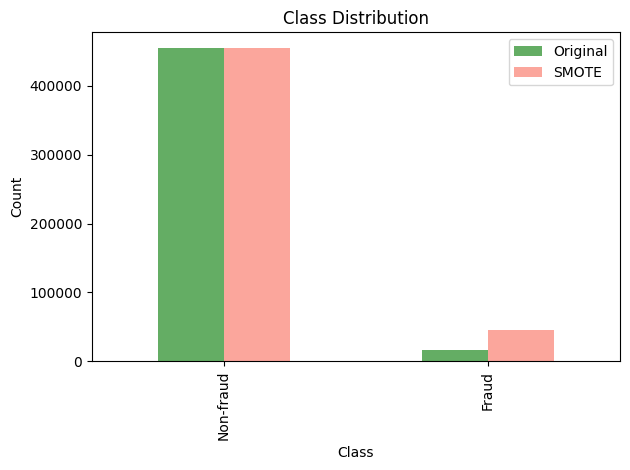


Training AUC: 0.9858

Validation AUC: 0.9383


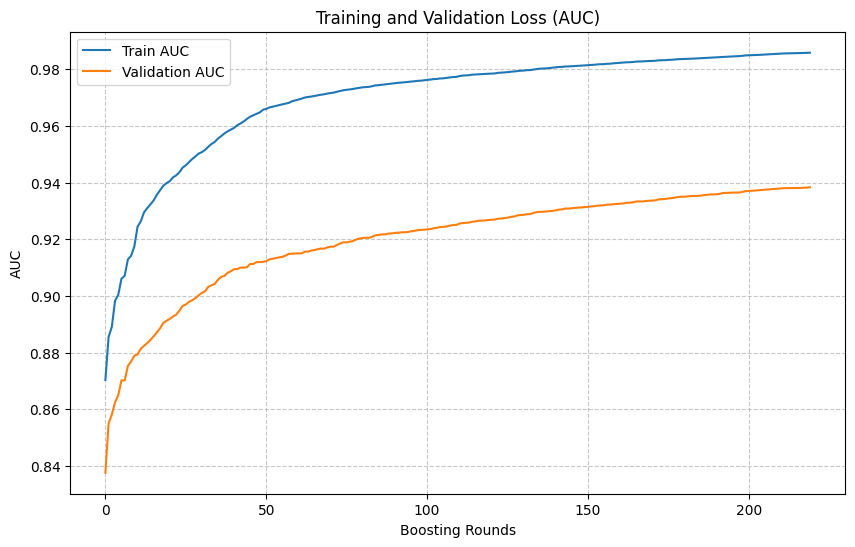

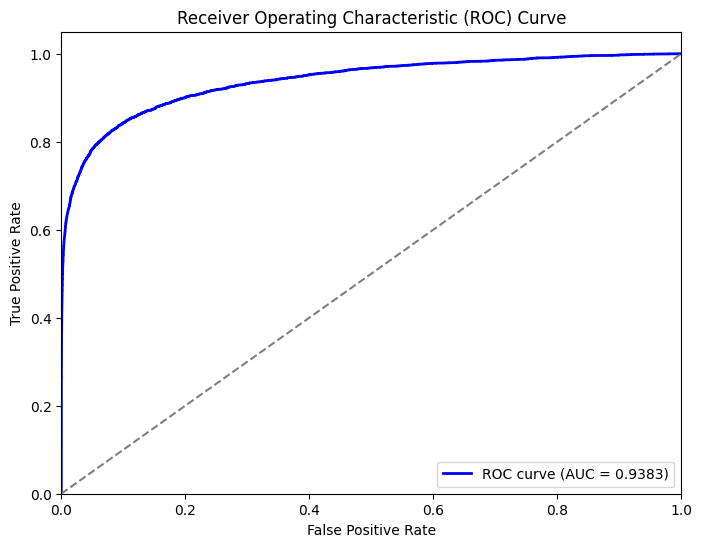

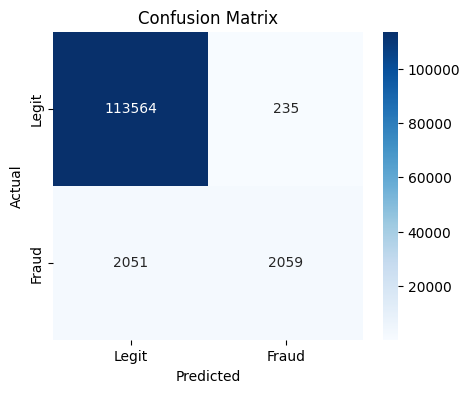

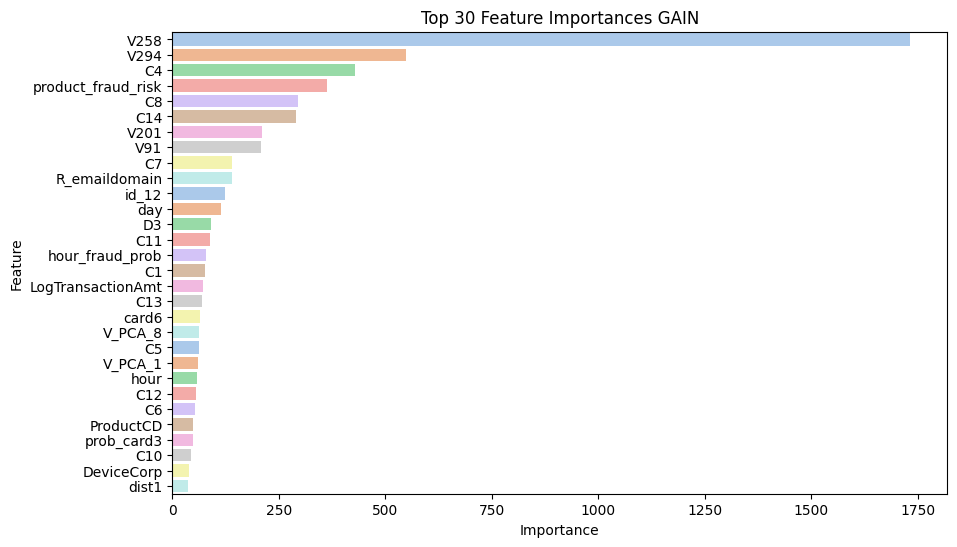

In [0]:
import pandas as pd
import numpy as np
import gc
import mlflow


with mlflow.start_run(run_name="MLflow features with PCA & SMOTE"):
  dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity = get_data_dtypes()

  # Load raw data
  train_transaction, train_identity, test_transaction, test_identity = load_raw_data(
      dtypes_train_transaction, dtypes_train_identity, dtypes_test_transaction, dtypes_test_identity, None
  )

  # Merge datasets
  train, test = merge_datasets(train_transaction, train_identity, test_transaction, test_identity)

  del train_transaction, train_identity, test_transaction, test_identity
  gc.collect()

  # Run feature engineering
  train, test = run_feature_engineering(train, test)

  # Prepare data for training
  X_train, X_val, y_train, y_val, X_test = prepare_data_for_training(train, test, impute=True)
  # Process categorical features
  X_train, X_val, X_test = reduce_v_features_selectively(X_train, X_val, X_test, n_components=40)
  X_train, X_val, X_test, numeric_features = standardize_numeric_features(X_train, X_val, X_test)
  categorical_features = get_categorical_features()
  X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

  # Print initial class distribution
  print("\nOriginal class distribution:")
  print(f"Fraud cases: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.2f}%)")
  print(f"Non-fraud cases: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.2f}%)")

  # Apply SMOTE to balance training data
  _, cat_indices = get_categorical_features_indices(X_train)
  smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42, sampling_strategy=0.1)
  X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

  print("\nClass distribution after SMOTE:")
  print(f"Fraud cases: {(y_train_resampled == 1).sum()} ({(y_train_resampled == 1).mean()*100:.2f}%)")
  print(f"Non-fraud cases: {(y_train_resampled == 0).sum()} ({(y_train_resampled == 0).mean()*100:.2f}%)")

  # Get model parameters and train
  model_params = get_model_params()
  model = train_model(X_train_resampled, X_val, y_train_resampled, y_val, model_params)

  plot_smote_class_distribution(y_train=y_train, y_train_resampled=y_train_resampled)

  # Evaluate model
  train_pred, train_auc = evaluate_model(model, X_train_resampled, y_train_resampled)
  print(f"\nTraining AUC: {train_auc:.4f}")
  val_pred, val_auc = evaluate_model(model, X_val, y_val)
  print(f"\nValidation AUC: {val_auc:.4f}")

  log_mlflow_artifacts(model, model_params, train_auc, val_auc, val_pred, y_val)

  # Generate test predictions
  test_predictions = model.predict_proba(X_test)[:, 1]

  export_test_predictions(test_predictions, test)

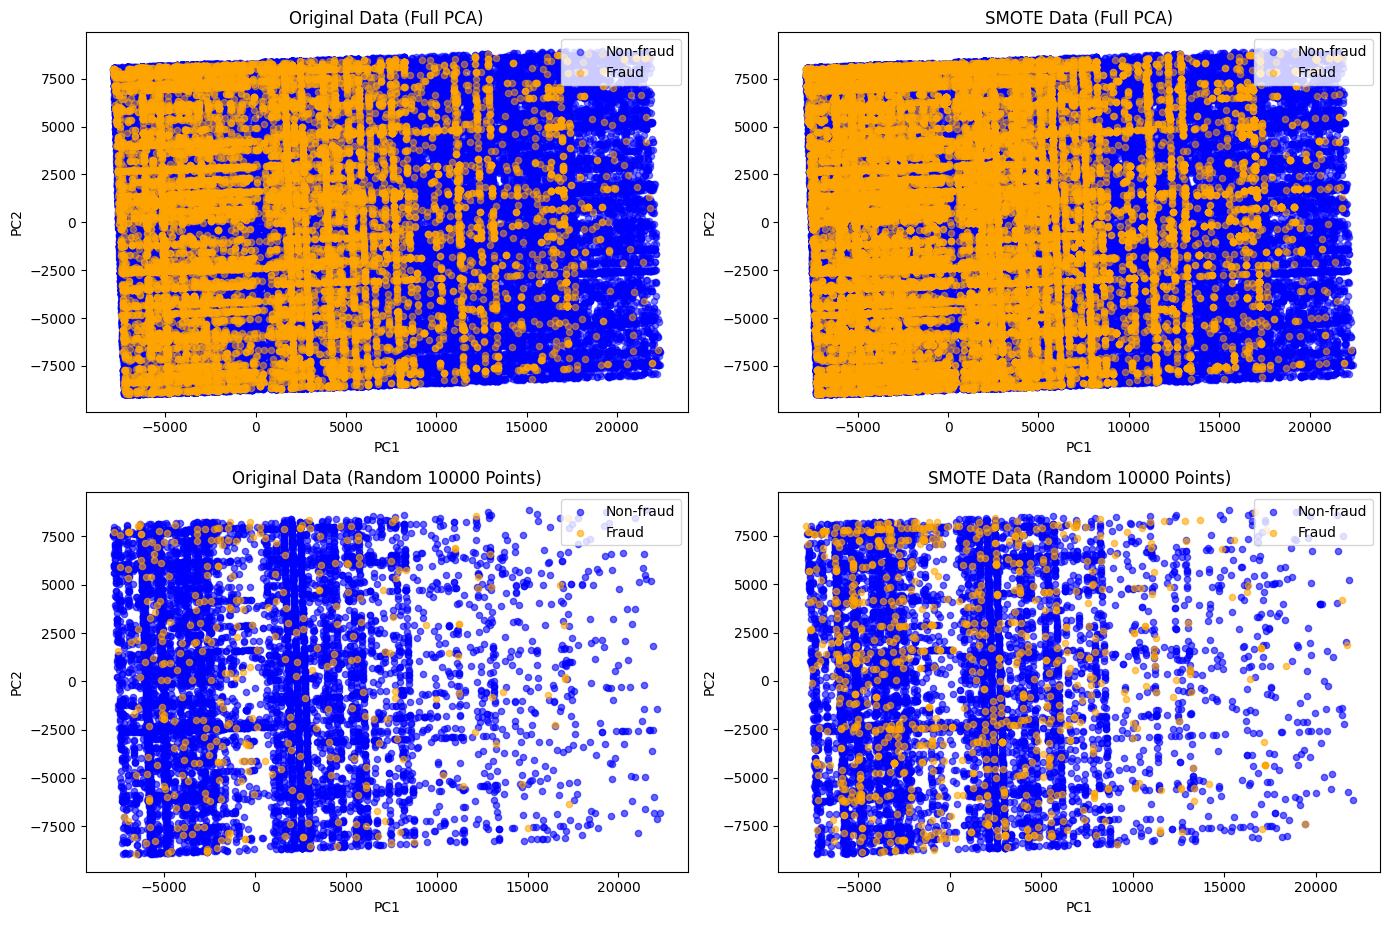

In [0]:
  # # Visualize SMOTE effect
visualize_smote_effect(X_train, y_train, X_train_resampled, y_train_resampled)